**AdaBoost композиция классификаторов** 

Евгений Борисов  <esborisov@sevsu.ru>

MachineLearning.ru : Алгоритм_AdaBoost   
http://www.machinelearning.ru/wiki/index.php?title=Алгоритм_AdaBoost

In [1]:
import numpy as np
from numpy import random as rng

import matplotlib.pyplot as plt

%precision 3
np.set_printoptions(precision=2)
np.set_printoptions(linewidth=110)
# np.get_printoptions()

# генерируем данные

(1024, 2)

(1024, 1)

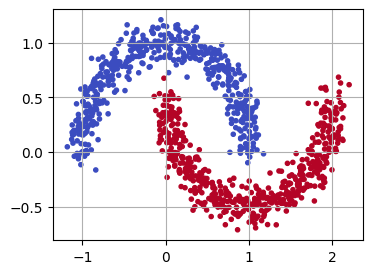

In [2]:
from sklearn.datasets import make_moons
X,target = make_moons(n_samples=1024, noise=.09)

# from sklearn.datasets import make_blobs
# X,target = make_blobs( n_samples=1024, centers=2,  cluster_std=[1.5, 1.8,] )

target = (2*target-1).reshape(-1,1)
display(X.shape, target.shape)

fig,ax = plt.subplots( figsize=(4,3),)
ax.scatter(x=X[:,0],y=X[:,1],c=target, marker='.', cmap='coolwarm')
ax.grid()

In [3]:
# target

In [4]:
# нормируем данные

# from sklearn.preprocessing import MinMaxScaler
# X = MinMaxScaler([-1.0,1.0]).fit_transform(X)

# from sklearn.preprocessing   import StandardScaler
# X = StandardScaler().fit(X).transform(X)

# display( X.min(),np.mean(X),np.median(X),X.max() 

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, target_train, target_test = train_test_split(X,target,test_size=.5)
display( X_train.shape, X_test.shape, )

assert len(target_train) == len(X_train)
assert len(target_test) == len(X_test)

del X,target

(512, 2)

(512, 2)

# модель

## базовая модель

пороговый классификатор отказами

$$
a(x;s,t) = s\cdot sign \left( x - t \right) ; s \in \lbrace-1,+1 \rbrace
$$

In [6]:
class DecisionStumbClassifier:
    
    def __init__( self, n_feature=0, threshold=0., sig=+1, ):
        self._threshold = threshold # порог значения
        self._n_feature = n_feature # номер признака
        self._sig = sig # знак классификатора ( > или < )
            
    def score(self,x): 
        assert len(x)>0
        assert len(x.shape)==2
        return ( x[:,[self._n_feature]] - self._threshold )
    
    def predict(self,x): 
        return self._sig * np.sign( self.score(x) ).astype(np.int8)
    
    @property
    def threshold(self): return self._threshold

    @threshold.setter
    def threshold(self,value): self._threshold = value    
        
    @property
    def n_feature(self): return self._n_feature

    @n_feature.setter
    def n_feature(self,value): self._n_feature = value            
        
    @property
    def sig(self): return self._sig

    @sig.setter
    def sig(self,value): self._sig = value      

In [7]:
# DecisionStumbClassifier().predict(X_train)

In [10]:
class TrainDecisionStumbClassifier:
    
    def __init__(self,model):
        self._model = model

    def fit( self, X, target, n_thresholds=7):
        err = self._search_split(X,target,n_thresholds) 
        return err, self._model
    
    # поиск оптимальной гиперплоскости 
    def _search_split( self, X, target, n_thresholds): # n_thresholds - количество порогов для перебора
        thresholds = self._get_thresholds(X,n_thresholds)
        
        n_features = X.shape[1] # размерность пространства, количество признаков
        
        self._model.sig = +1
        # оценка классификатора для каждого признака и порога 
        errors = self._errors_matrix(X,target,thresholds)
        # индексы минимального значения в матрице ошибок
        n_threshold_plus,n_feature_plus = np.unravel_index(errors.argmin(),errors.shape)
        err_plus = errors[n_threshold_plus,n_feature_plus]

        self._model.sig = -1
        # оценка классификатора для каждого признака и порога 
        errors = self._errors_matrix(X,target,thresholds)
        # индексы минимального значения в матрице ошибок
        n_threshold_minus,n_feature_minus = np.unravel_index(errors.argmin(),errors.shape)
        err_minus = errors[n_threshold_minus,n_feature_minus]
        
        if err_minus<err_plus:
            self._model.threshold = thresholds[n_threshold_minus,n_feature_minus]
            self._model.n_feature = n_feature_minus     
            return errors[n_threshold_minus,n_feature_minus]
        
        self._model.threshold = thresholds[n_threshold_plus,n_feature_plus]
        self._model.n_feature = n_feature_plus     
        return errors[n_threshold_plus,n_feature_plus]
             
        
    @staticmethod        
    def _get_thresholds(X,n_thresholds):
        # min и max для каждого признака
        xmm = np.vstack([X.min(axis=0), X.max(axis=0),]).T
        # список порогов для каждого признака
        return np.linspace( start=xmm[:,0], stop=xmm[:,1], num=n_thresholds )[1:-1]

    
    def _errors_matrix(self,X,target,thresholds):
        n_features = thresholds.shape[1]
        n_thresholds = thresholds.shape[0]
        # оценка классификатора для каждого признака и порога 
        return np.array([ 
                [ 
                    self._criterium(
                            X,target,
                            n_feature=n_feature,
                            threshold=thresholds[n_threshold,n_feature],
                        ) 
                    for n_feature in range(n_features)  
                ]
                for n_threshold in range(n_thresholds) 
            ])
        
    def _criterium(self,x,target,n_feature,threshold):
        # взвешенная суммарная ошибка    
        return (self._errors(x,target,n_feature,threshold)).sum()

    # ошибки классификатора
    def _errors(self,x,target,n_feature,threshold):
        self._model.threshold = threshold
        self._model.n_feature = n_feature
        o = self._model.predict(x) # ответ классификатора
        return ((o*target)<0).astype(int) # ответ ошибочный и не отказ (!=0)

In [21]:
err,model = TrainDecisionStumbClassifier(model=DecisionStumbClassifier()).fit(X_train,target_train)
display( 1.-(err/len(target_train)) ) # accuracy
display(( model.n_feature, model.sig, model.threshold,) )

0.826

(1, -1, 0.236)

              precision    recall  f1-score   support

          -1       0.85      0.87      0.86       258
           1       0.86      0.85      0.86       254

    accuracy                           0.86       512
   macro avg       0.86      0.86      0.86       512
weighted avg       0.86      0.86      0.86       512



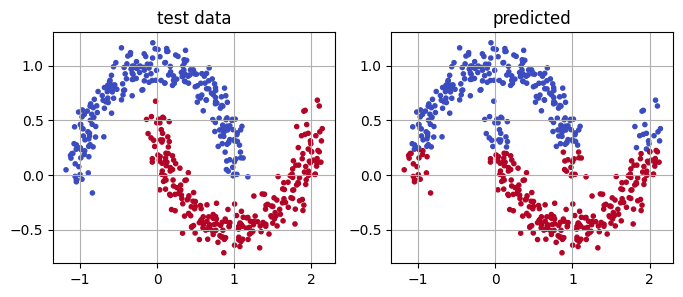

In [22]:
from sklearn.metrics import classification_report

predicted = model.predict(X_test)

print(classification_report( target_test, predicted) )

fig,ax = plt.subplots(1,2, figsize=(8,3),)
ax[0].scatter(x=X_test[:,0],y=X_test[:,1],c=target_test, marker='.', cmap='coolwarm')
ax[0].set_title('test data')
ax[0].grid()
ax[1].scatter(x=X_test[:,0],y=X_test[:,1],c=predicted, marker='.', cmap='coolwarm')
ax[1].set_title('predicted')
ax[1].grid()

In [ ]:
class WeigtedTrainDecisionStumbClassifier(TrainDecisionStumbClassifier):
    
    def __init__(self,model):
        super().__init__(model)
        self._xweight = 1.
        
    def fit( self, X, xweight, target, n_thresholds=7 ):
        self._xweight = xweight
        return super().fit(X,target,n_thresholds)
    
    def _criterium(self,x,target,n_feature,threshold):
        # взвешенная суммарная ошибка    
        return self._errors(x,target,n_feature,threshold).T.dot(self._xweight).flatten()[0]

In [ ]:
## 

взвешенное голосование AdaBoost 

$$
a(x) = sign \left( \sum_{i=1}^T w_i \cdot b_i(x) \right)
$$

In [ ]:
class AdaBoostClassifier:
    
    def __init__( self, weight=[], base=[] ):
        assert len(weight)==len(base), f'weight {len(weight)}, base {len(base)}'
        
        self._weight = weight
        self._base = base
            
    def score(self,x):
        assert len(x)>0
        return np.hstack([ b.predict(x) for b in self._base ]).dot( self._weight )
    
    def predict(self,x): 
        return np.sign( self.score(x) ).astype(np.int8)  
   
    @property
    def weight(self): return self._weight

    @weight.setter
    def weight(self,value): self._weight = value
        
    @property
    def base(self): return self._base

    @base.setter
    def base(self,value): self._base = value
     
    def append(self,model,weight):
        if len(self._weight)>0:
            self._weight = np.vstack( [self._weight,[weight]] )
            self._weight = self._weight/self._weight.sum() 
        else:
            self._weight = np.array([[weight]])

        self._base.append(model)
            
        return self
    
    def __del__(self):
        del self._base

In [ ]:
# AdaBoostClassifier()

In [ ]:
from sklearn.metrics import accuracy_score
# sklearn.metrics.accuracy_score(y_true, y_pred,

In [ ]:
class TrainAdaBoost:
    
    def __init__(self,ensemble, base,base_train ):
        self._ensemble = ensemble
        self._base = base
        self._base_train = base_train

    def fit(self,X,target,n_epoch=14,acc_min=.99):
        assert len(X)>1
        assert len(X)==len(target)
        assert len(X.shape)==2
        assert len(target.shape)==2
        assert target.shape[1]==1
        
        n_samples = X.shape[0]
        d = 1./n_samples # добавка для расчёта веса компоненты на случай отсутствия ошибок 

        xweight = np.ones(shape=(n_samples,1))/n_samples
        
        acc_history = [0.]
        loss_history = [10.]
        
        for jj in range(n_epoch):
            model = self._base()
            _,model = self._base_train( model=model ).fit(X,target,n_thresholds=32,xweight=xweight)

            o = model.predict(X)

            p = ((o*target>0)*xweight).sum() # сумма весов правильных ответов
            n = ((o*target<0)*xweight).sum() # сумма весов ошибочных ответов

            print(n,p)
            
            # базовый классификатор должен выдавать результат лучше чем случайный выбор 
            # if( n < .5 ):
            a = np.log((p+d)/(n+d)) # вычисляем вес классификатора
            self._ensemble.append(model,a)
            # обновляем веса объектов
            xweight = xweight * np.exp( -a*target*o )
            xweight = xweight/xweight.sum()

            p = self._ensemble.predict(X)
            acc_history.append( accuracy_score( target, p) ) # значение погрешности композиции
            loss_history.append( self._loss(target,p) ) # значение погрешности композиции
            
            if acc_history[-1] > acc_min: # проверяем достижение минимального порога погрешности модели
                 break
            
            #print( a, xweight.T )
        
        return (acc_history,loss_history), self._ensemble
    
    # значение ф-ции потери для композиции классификаторов
    def _loss(self,target,predicted): 
        return np.exp( -target * predicted ).sum()/len(target)

In [ ]:
# del model

In [ ]:
model = AdaBoostClassifier()
(acc_history,loss_history),model = TrainAdaBoost(
         ensemble=model,
         base=DecisionStumbClassifier,
         base_train=TrainDecisionStumbClassifier,
     ).fit(X_train,target_train)

In [ ]:
# model.score(X_test)
display(len(model.base) )
display(model.weight) 

In [ ]:
fig,ax = plt.subplots(ncols=2, figsize=(8,3),)
ax[0].plot(acc_history,c='r')
ax[0].set_title(f'acc_history,max:{max(acc_history):.3f}')
ax[0].grid()
ax[1].plot(loss_history,c='b')
ax[1].set_title(f'loss_history,min:{min(loss_history):.3f}')
ax[1].grid()

In [ ]:
# model.weight.shape
# # model.base
# np.hstack([ b.predict(X_train) for b in model.base ]).dot(model.weight.T)

In [ ]:
[ ( b.sig, b.n_feature, b.threshold ) for b in model.base ]

In [ ]:
from sklearn.metrics import classification_report

predicted = model.predict(X_test)

print(classification_report( target_test, predicted) )

fig,ax = plt.subplots(1,2, figsize=(8,3),)
ax[0].scatter(x=X_test[:,0],y=X_test[:,1],c=target_test, marker='.', cmap='coolwarm')
ax[0].set_title('test data')
ax[0].grid()
ax[1].scatter(x=X_test[:,0],y=X_test[:,1],c=predicted, marker='.', cmap='coolwarm')
ax[1].set_title('predicted')
ax[1].grid()

## карта скоров

In [ ]:
# строим сетку 

n = 50 # количество разбиений сетки

xx,yy = np.meshgrid(
    np.linspace( X_test[:,0].min()-0.1, X_test[:,0].max()+0.1, n), 
    np.linspace( X_test[:,1].min()-0.1, X_test[:,1].max()+0.1, n)
) # узлы сетки
display( ( xx.shape, yy.shape ) )

xy = np.vstack([xx.ravel(),yy.ravel() ]).T # разворачиваем сетку 
display( xy.shape )

# plt.figure(figsize=(7,7))
# plt.scatter( x=xy[:,0], y=xy[:,1], s=1 )
# plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# вычисляем скор для каждого узла сетки
score_xy = model.score(xy)
score_xy = MinMaxScaler(feature_range=(0.,1.)).fit_transform( score_xy )
score_xy = score_xy.reshape(n,n) 

In [ ]:
from matplotlib.colors import ListedColormap
fig,ax = plt.subplots(figsize=(6,4),sharey=True)
ax.contourf(xx, yy, score_xy )
ax.scatter( x=X_test[:,0], y=X_test[:,1], c=target_test, alpha=.5, s=5,  cmap='coolwarm' )
#ax[0].grid()

In [ ]:
# вычисляем скор для каждого узла сетки
predict_xy = model.predict( xy ).reshape(n,n) 

fig,ax = plt.subplots(figsize=(6,4),sharey=True)
ax.contourf(xx, yy, predict_xy, cmap=ListedColormap(['#0d1','#ee0']) )
ax.scatter( x=X_test[:,0], y=X_test[:,1], c=target_test, alpha=.5, s=5,  cmap='coolwarm' )

In [9]:
# class TrainDecisionStumbClassifier:
    
#     def __init__(self,model):
#         self._model = model

#     def fit( self, X, target, n_thresholds=7, xweight=1. ):
#         err = self._search_split( X, target, n_thresholds, xweight ) 
#         return err, self._model
    
#     # поиск оптимальной гиперплоскости 
#     def _search_split( self, X, target, n_thresholds, xweight): # n_thresholds - количество порогов для перебора
#         thresholds = self._get_thresholds(X,n_thresholds)
        
#         n_features = X.shape[1] # размерность пространства, количество признаков
        
#         self._model.sig = +1
#         # оценка классификатора для каждого признака и порога 
#         errors = self._errors_matrix(X,target,xweight,thresholds)
#         # индексы минимального значения в матрице ошибок
#         n_threshold_plus,n_feature_plus = np.unravel_index(errors.argmin(),errors.shape)
#         err_plus = errors[n_threshold_plus,n_feature_plus]

#         self._model.sig = -1
#         # оценка классификатора для каждого признака и порога 
#         errors = self._errors_matrix(X,target,xweight,thresholds)
#         # индексы минимального значения в матрице ошибок
#         n_threshold_minus,n_feature_minus = np.unravel_index(errors.argmin(),errors.shape)
#         err_minus = errors[n_threshold_minus,n_feature_minus]
        
#         if err_minus<err_plus:
#             self._model.threshold = thresholds[n_threshold_minus,n_feature_minus]
#             self._model.n_feature = n_feature_minus     
#             return errors[n_threshold_minus,n_feature_minus]
        
#         self._model.threshold = thresholds[n_threshold_plus,n_feature_plus]
#         self._model.n_feature = n_feature_plus     
#         return errors[n_threshold_plus,n_feature_plus]
             
        
#     @staticmethod        
#     def _get_thresholds(X,n_thresholds):
#         # min и max для каждого признака
#         xmm = np.vstack([X.min(axis=0), X.max(axis=0),]).T
#         # список порогов для каждого признака
#         return np.linspace( start=xmm[:,0], stop=xmm[:,1], num=n_thresholds )[1:-1]

    
#     def _errors_matrix(self,X,target,xweight,thresholds):
#         n_features = thresholds.shape[1]
#         n_thresholds = thresholds.shape[0]
#         # оценка классификатора для каждого признака и порога 
#         return np.array([ 
#                 [ 
#                     self._criterium(
#                             X,target,
#                             n_feature=n_feature,
#                             threshold=thresholds[n_threshold,n_feature],
#                             xweight=xweight,
#                         ) 
#                     for n_feature in range(n_features)  
#                 ]
#                 for n_threshold in range(n_thresholds) 
#             ])
        
#     def _criterium(self,x,target,n_feature,threshold,xweight):
#         # взвешенная суммарная ошибка    
#         return (self._errors(x,target,n_feature,threshold)*xweight).sum()

#     # ошибки классификатора
#     def _errors(self,x,target,n_feature,threshold):
#         self._model.threshold = threshold
#         self._model.n_feature = n_feature
#         o = self._model.predict(x) # ответ классификатора
#         return ((o*target)<0).astype(int) # ответ ошибочный и не отказ (!=0)